# M. Caiola, L. Cusin, G. Serafini, A. Tonello 

# Dataset


The data was recorded by the pathology and hematology departments at Libya's Sebha Oncology Center. The information was gathered from BC cases that were recorded at the center between 2015 and 2020, Which represents the time limits of the study. The inclusion criteria were *all Libyan cases from different regions who were registered during the study at the SOC*.

Biomarkers and tumor markers are molecules used to detect the presence of cancer, monitor it, and evaluate its response to treatment. In the case of breast cancer, these markers could be proteins, genes, or their products that are found in abnormal levels in the body.

The role of biomarkers in diagnosing breast cancer are:

 1) Early detection: Vital signs help detect cancer in its early stages, which increases the chances of successful treatment.
 2) Diagnosis: Some vital signs can be used to determine the type of breast cancer and its stages of development.
 3) Treatment evaluation: It helps evaluate the effectiveness of the ongoing treatment and monitor the progression of the disease.

Biomarker used in our analysis to discover breast cancer:

CA 15-3 and CEA: these are proteins found in elevated levels in some types of breast cancer, and are used to monitor treatment.


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# for VIF calculation
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [75]:
%load_ext autoreload
%autoreload 2

import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
file_path = './data/BC.csv'
data = pd.read_csv(file_path)

data.head()

,Sex,Age,Adress,FBS,Urea,Creatinin,ALB,T_Ca,GPT,GOT,...,WBC,RBC,HGB,PLT,ESR,LDH,Na,K,CL,CLASS
0,1,60,Tragan,100,23,0.8,3.4,10.0,20,10,...,3.4,4.60,13.4,196,14,150,145.0,4.50,107.1,0
1,1,53,Sabha,190,27,0.6,4.2,9.3,11,17,...,4.4,5.00,12.5,155,15,260,139.2,4.17,106.4,0
2,1,50,Sabha,150,15,1.1,3.5,8.5,13,10,...,5.1,4.46,13.8,312,15,169,140.0,4.00,100.1,0
3,1,36,Obaree-center,80,20,1.0,4.2,8.0,7,13,...,3.1,4.33,10.7,212,10,138,136.4,4.06,107.1,0
4,1,30,Obaree-center,80,40,0.8,3.0,9.5,9,15,...,4.2,4.13,12.3,243,5,154,142.3,4.00,106.2,0


This is a brief description of the variables:

1. **Sex**: Biological sex of the individual (e.g., 1 = Male, 2 = Female)

2. **Age**: Age of the individual in years
3. **Address**: Location or residence of the individual (likely categorical)
4. **FBS**: Fasting Blood Sugar (mg/dL), a measure of blood glucose after fasting.
5. **Urea**: Blood urea level (mg/dL), a measure of kidney function.
6. **Creatinin**: Serum creatinine level (mg/dL), a marker for kidney function.
7. **ALB**: Albumin (g/dL), a protein in the blood, indicative of liver or kidney health.
8. **T_Ca**: Total Calcium (mg/dL), important for bone health and metabolic functions.
9. **GPT (ALT)**: Alanine Aminotransferase (U/L), a liver enzyme used to assess liver function.
10. **GOT (AST)**: Aspartate Aminotransferase (U/L), another liver enzyme indicative of liver health.
11. **ALP**: Alkaline Phosphatase (U/L), a liver and bone enzyme.
12. **CA15**: Cancer Antigen 15-3 (U/mL), often used as a tumor marker for breast cancer.
13. **CEA**: Carcinoembryonic Antigen (ng/mL), a marker for various cancers.
14. **WBC**: White Blood Cell count (×10³/µL), a measure of immune system activity.
15. **RBC**: Red Blood Cell count (×10⁶/µL), indicative of oxygen-carrying capacity.
16. **HGB**: Hemoglobin (g/dL), the oxygen-carrying protein in red blood cells.
17. **PLT**: Platelet count (×10³/µL), involved in blood clotting.
18. **ESR**: Erythrocyte Sedimentation Rate (mm/hour), a marker for inflammation.
19. **LDH**: Lactate Dehydrogenase (U/L), an enzyme linked to tissue damage.
20. **Na**: Sodium (mEq/L), an essential electrolyte.
21. **K**: Potassium (mEq/L), another critical electrolyte for muscle and heart function.
22. **CL**: Chloride (mEq/L), an electrolyte that helps maintain fluid balance.
23. **CLASS**: Response variable stating if the cancer if benign or malignant.

 The response variable is $\texttt{CLASS}$: $\quad$ 0 = Benign cancer, 1 = Malignant cancer

# Goal of our project
Provide a comprehensive analysis of the predictors for Benign or Malignant breast cancer, to establish whether the two biomarkers are enough to interpret the results. We explore the variables using various feature selection methods

# Exploratory Data Analysis

First, we search for missing values

In [77]:
missing_values = data.isnull().sum()
missing_values

Sex          0
Age          0
Adress       0
FBS          0
Urea         0
Creatinin    0
ALB          0
T_Ca         0
GPT          0
GOT          0
ALP          0
CA15         0
CEA          0
WBC          0
RBC          0
HGB          0
PLT          0
ESR          0
LDH          0
Na           0
K            0
CL           0
CLASS        0
dtype: int64

The dataset shows no missing values. We can proceed 

## class_counts = data['CLASS'].value_counts(normalize=True) * 100
print(class_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='CLASS', data=data, palette= 'viridis', hue = 'CLASS', legend = False)
plt.title('Distribution of the Target Variable (CLASS)')
plt.xlabel('CLASS')
plt.ylabel('Count')
plt.show()

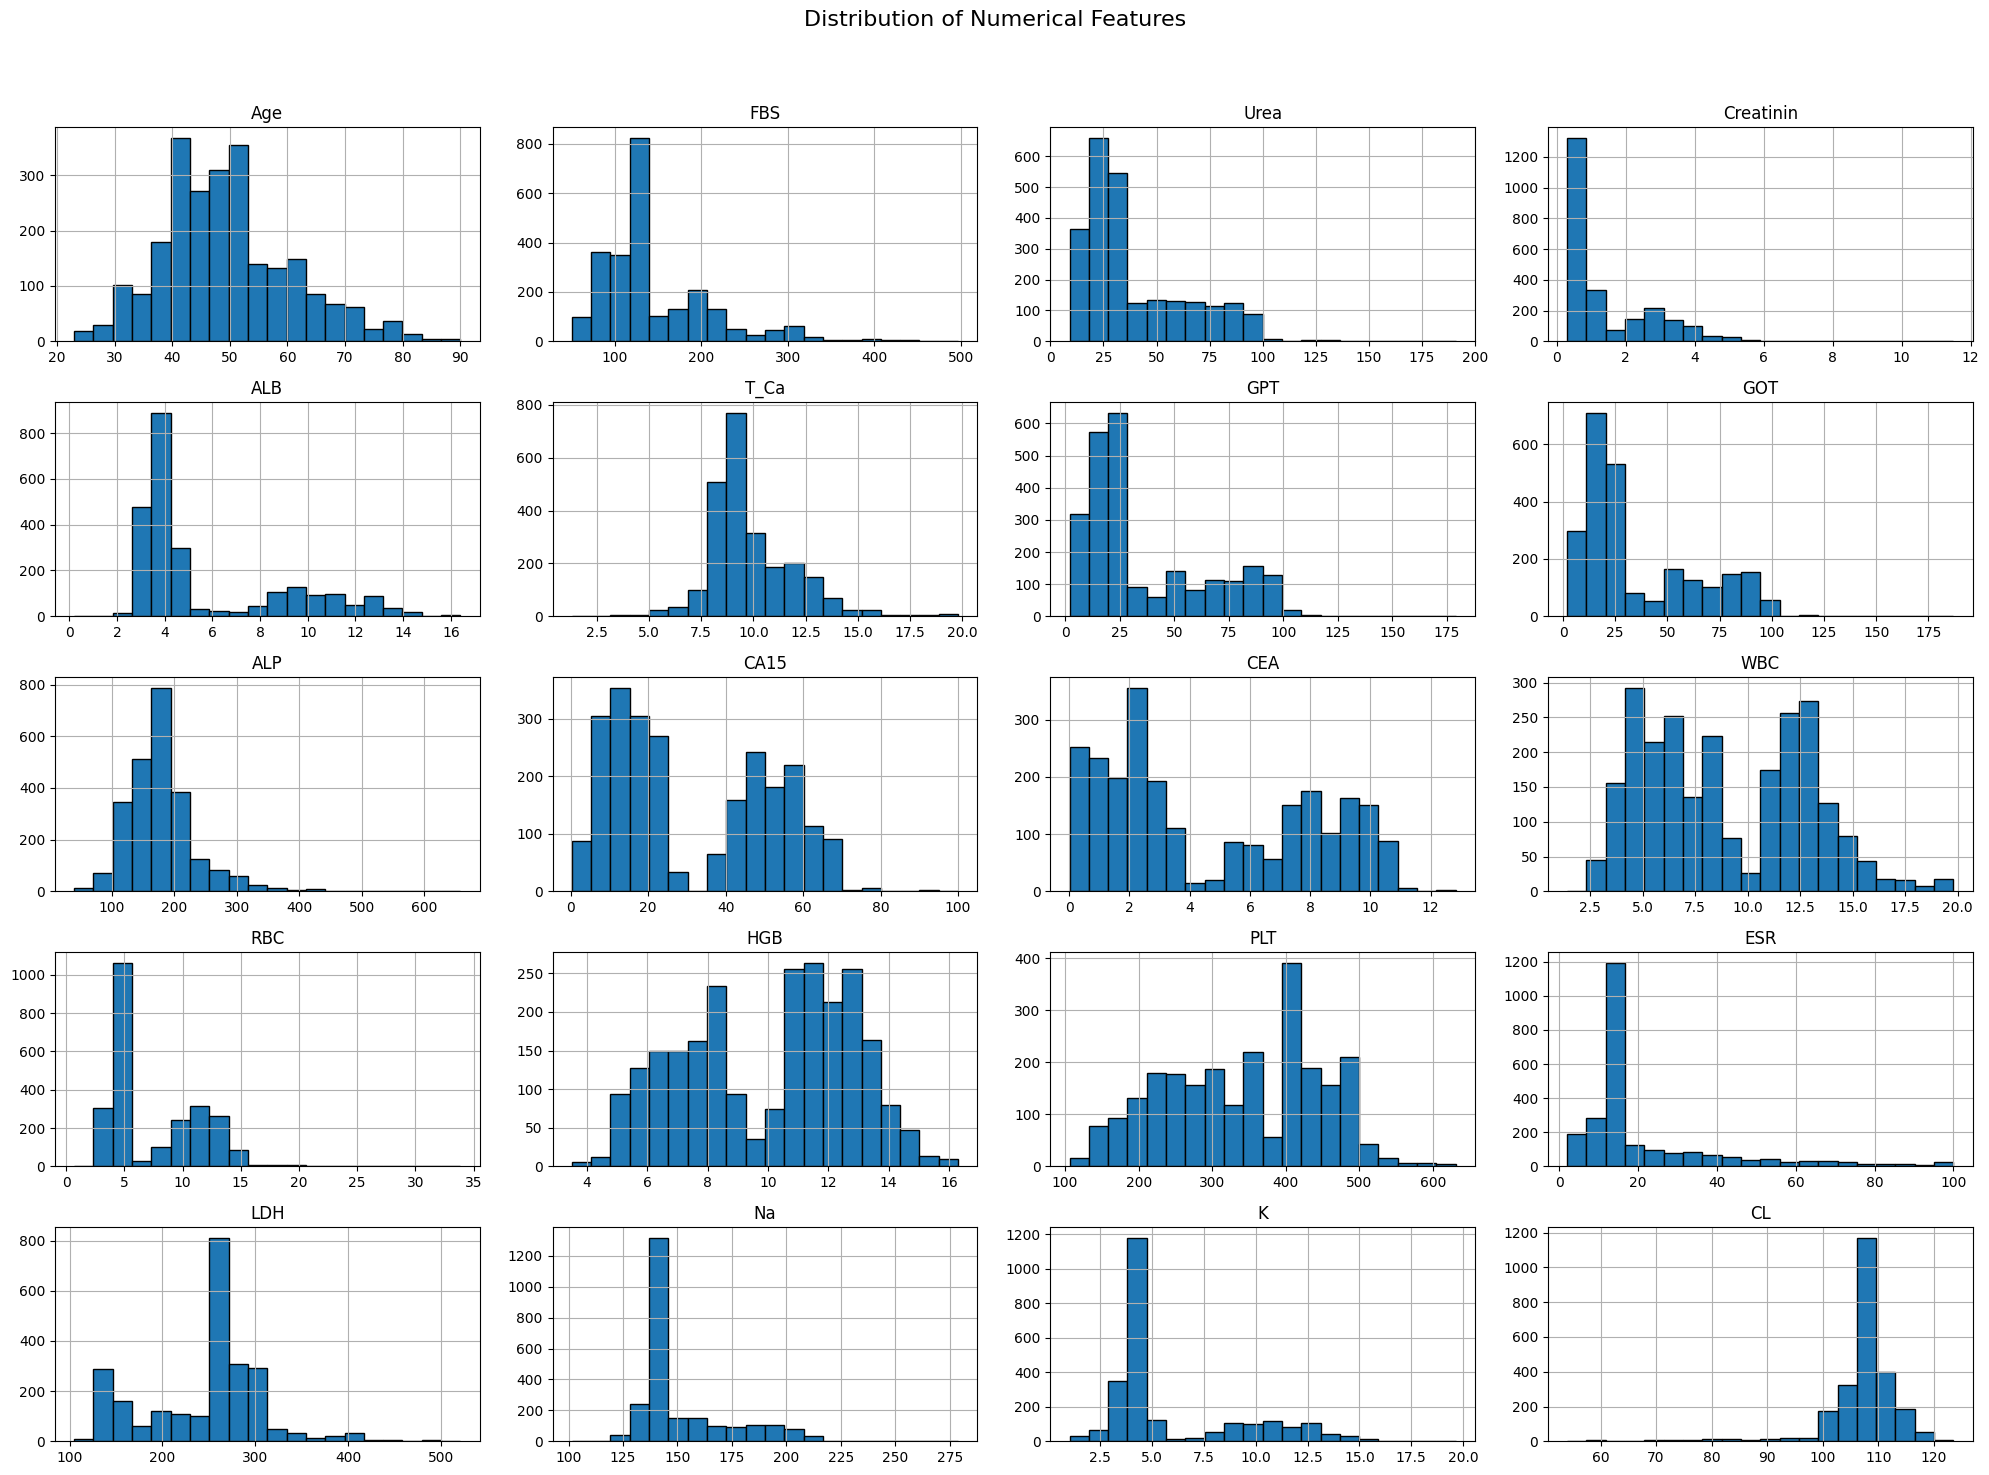

In [78]:
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.drop(['CLASS', 'Sex'])
data[numerical_features].hist(figsize=(20, 15), bins=20, edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Categorization of Variables by Type and Purpose

Categorizing the variables is essential for effectively organizing and interpreting the dataset. Dividing the variables into distinct groups (demographic, biochemical and clinical, and cancer-specific biomarkers) helps identify relevant patterns, analyze significant correlations, and structure the analysis better for predicting the target variable. This segmentation also aids in understanding the role of each variable in the medical and diagnostic context.


## Demographic and categorial variables
Adress  -  Age  -  Sex

### *Adress* 

Given the high number of sampled cities, we chose to categorize them into the three major Libian regions: Tripolitania, Cirenaica and Fezzan

In [79]:
data = data.rename(columns={'Adress': 'Address'})
data['Address'].unique()

array(['Tragan', 'Sabha', 'Obaree-center', 'Alchate', 'Morzek',
       'Alzeegan', 'Algatroon', 'Godoha', 'Zoiwela', 'OmAlrianb',
       'Tripoli', 'Wade-atebah', 'Temaciha', 'Algofra', 'Gath',
       'Benwalid', 'Temcian', 'Alzwia-Algrbia', 'Magdool', 'BenGawoad',
       'Alagialt', 'Agdabia', 'GaberOan', 'Subrath', 'ALzentan',
       'Benghazi', 'Tegee', 'Graian', 'Zwoarha', 'sabha'], dtype=object)

In [80]:
# Definizione delle regioni
Tripolitania = [
    'Tripoli', 'Benwalid', 'Subrath', 'ALzentan', 'Tegee', 'Graian', 
    'Zwoarha', 'Alagialt', 'Zoiwela'
]
Cirenaica = [
    'Benghazi', 'Agdabia', 'GaberOan', 'Alzwia-Algrbia', 'Magdool', 
    'BenGawoad', 'Alzeegan'
]
Fezzan = [
    'Sabha', 'sabha' ,'Tragan', 'Obaree-center', 'Alchate', 'Morzek', 'Algatroon', 
    'Godoha', 'OmAlrianb', 'Wade-atebah', 'Temaciha', 'Algofra', 'Gath', 'Temcian'
]

# Funzione per classificare le regioni
def classify_region_numeric(adress):
    if adress in Tripolitania:
        return 1  # Tripolitania
    elif adress in Cirenaica:
        return 2  # Cirenaica
    elif adress in Fezzan:
        return 3  # Fezzan


# Applica la funzione alla colonna 'Adress' e assicurati che il risultato sia di tipo intero
data['Address'] = data['Address'].apply(classify_region_numeric)

# Visualizza i risultati
#print(data['Adress'])

In [81]:
count_Tripolitania = len(data[(data['Address'] == 1)])
count_Cirenaica = len(data[(data['Address'] == 2)])
count_Fezzan = len(data[(data['Address'] == 3)])
print(count_Tripolitania)
print(count_Cirenaica)
print(count_Fezzan)

88
46
2301


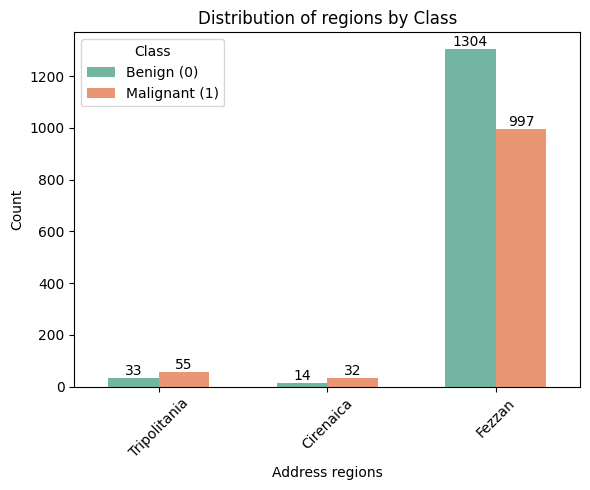

In [82]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=data, x='Address', hue='CLASS', palette='Set2', width=0.6)

# Add numbers on top of each bar
for bar in ax.patches:
    if bar.get_height() > 0:  # Only add text if height > 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
            bar.get_height(),                  # y-coordinate (height of the bar)
            int(bar.get_height()),             # Text (height value)
            ha='center', va='bottom',          # Alignment
            fontsize=10                        # Font size
        )

# Replace x-axis labels with custom names
custom_labels = ['Tripolitania', 'Cirenaica', 'Fezzan']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

plt.title('Distribution of regions by Class')
plt.xlabel('Address regions')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'], loc="upper left")
plt.tight_layout()

plt.show()

As an initial educated guess, Adress will probably have a small impact on the predictions, since almost all individuals were sampled in the same region (Fezzan)

### *Age da rivedere*

Following a similar reasoning, we also created three major age groups. The thresholds were chosen to reflect known ages brackets. Usually, the most affected individuals are women of older age.

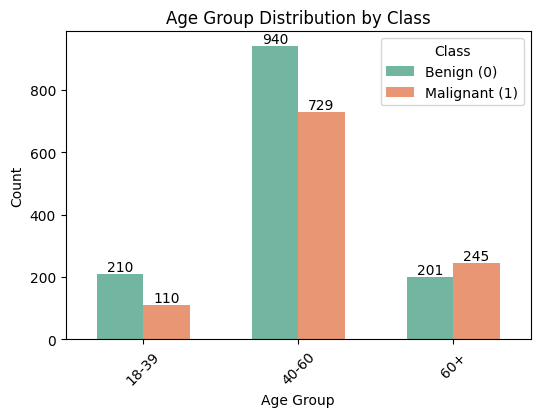

In [83]:
# Define the bins and labels
bins = [18, 39, 60, float('inf')]  # age ranges
labels = [1,2,3]  # 1=18-39, 2=40-60, 3=60+

# Categorize the ages into groups
data['Age'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# Create the grouped bar plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=data, x='Age', hue='CLASS', palette='Set2', width=0.6)  # width set to 0.6

# Add numbers on top of each bar
for bar in ax.patches:
    if bar.get_height() > 0:  # Only add text if height > 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
            bar.get_height(),                  # y-coordinate (height of the bar)
            int(bar.get_height()),             # Text (height value)
            ha='center', va='bottom',          # Alignment
            fontsize=10                        # Font size
        )
# Replace x-axis labels with custom names
custom_labels = ['18-39', '40-60', '60+']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

# Add labels and title
plt.title('Age Group Distribution by Class')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'])
plt.show()

The barplots reflect what previously mentioned. Middle-aged people were the most sampled, but breast cancer is more prevalent in individuals aged 60+

### *Sex*

We expect breast cancer to have a much larger impact on female individuals.

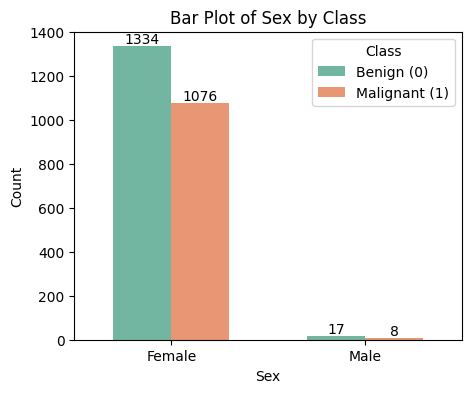

In [84]:
# Create the bar plot
plt.figure(figsize=(5, 4))
ax = sns.countplot(data=data, x='Sex', hue='CLASS', palette='Set2', width=0.6)

# Add numbers on top of each bar
for bar in ax.patches:
    if bar.get_height() > 0:  # Only add text if height > 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
            bar.get_height(),                  # y-coordinate (height of the bar)
            int(bar.get_height()),             # Text (height value)
            ha='center', va='bottom',          # Alignment
            fontsize=10                        # Font size
        )

custom_labels = ['Female', 'Male']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

# Add labels and title
plt.title('Bar Plot of Sex by Class')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'])
plt.show()

Almost all sampled individuals are females. Again, we can deduce that the Sex variable won't have much impact on the prediction.

In [85]:
count_class_0 = len(data[(data['Sex'] == 1) & (data['CLASS'] == 0)])
count_class_1 = len(data[(data['Sex'] == 1) & (data['CLASS'] == 1)])

print(count_class_0)
print(count_class_1)

print()
count_class_2 = len(data[(data['Sex'] == 2) & (data['CLASS'] == 0)])
count_class_3 = len(data[(data['Sex'] == 2) & (data['CLASS'] == 1)])
print(count_class_2)
print(count_class_3)


1334
1076

17
8


## Biochemical and Clinical Variables
FBS - Urea - Creatinin - ALB - T_Ca - GPT (ALT) - GOT (AST) - ALP - WBC - RBC - HGB - PLT - ESR - LDH - Na - K - CL

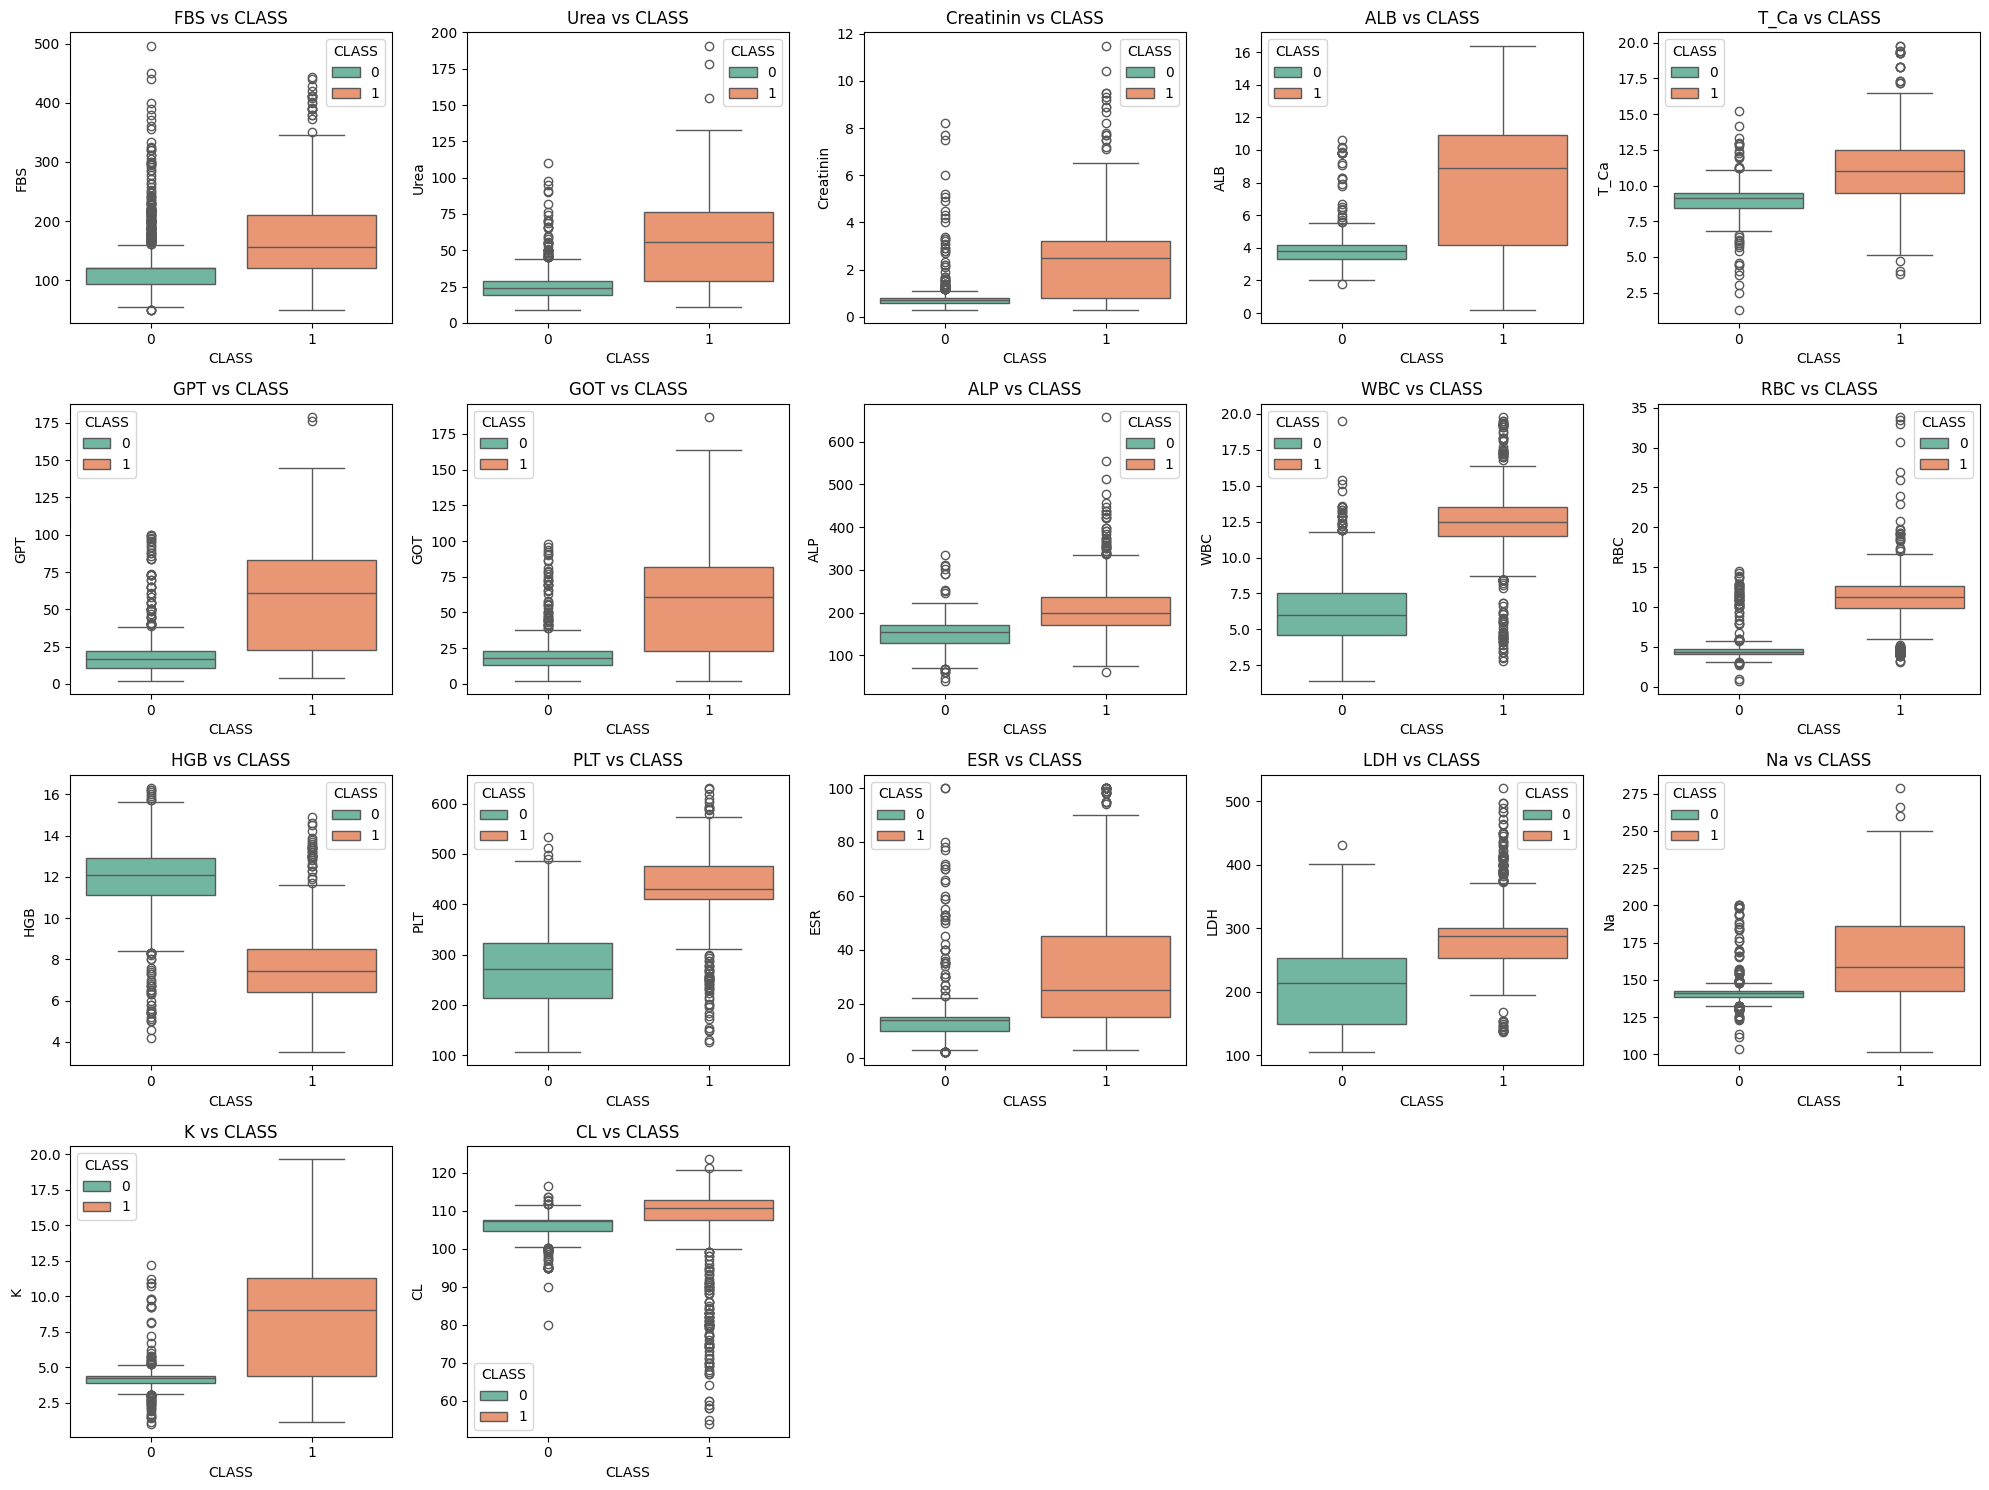

{'Correlations': CLASS        1.000000
 RBC          0.806285
 WBC          0.806098
 PLT          0.757423
 GOT          0.674769
 GPT          0.669495
 ALB          0.661895
 Urea         0.628102
 LDH          0.626307
 K            0.606510
 Creatinin    0.591893
 Na           0.547047
 ALP          0.542504
 ESR          0.519487
 T_Ca         0.499334
 FBS          0.391418
 CL           0.139497
 HGB         -0.789147
 Name: CLASS, dtype: float64}

In [86]:
biochemical_clinical_vars = [
    'FBS', 'Urea', 'Creatinin', 'ALB', 'T_Ca', 'GPT', 'GOT', 'ALP',
    'WBC', 'RBC', 'HGB', 'PLT', 'ESR', 'LDH', 'Na', 'K', 'CL'
]

correlations = data[biochemical_clinical_vars + ['CLASS']].corr()['CLASS'].sort_values(ascending=False)

plt.figure(figsize=(20, 15))
for i, var in enumerate(biochemical_clinical_vars, 1):
    plt.subplot(4, 5, i)
    sns.boxplot(data=data, x='CLASS', y=var, palette="Set2", hue='CLASS')
    plt.title(f'{var} vs CLASS')
    plt.xlabel('CLASS')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

{
    "Correlations": correlations
}


### Results summary:

The correlation analysis reveals key insights into the relationship between biochemical and clinical variables with the target variable `CLASS` (cancer presence). Variables like **RBC**, **WBC**, and **PLT** show strong positive correlations (>0.75), suggesting that higher levels of these markers are strongly associated with cancer. Similarly, liver function enzymes such as **GOT** and **GPT**, as well as markers like **ALB**, **Urea**, and **LDH**, also demonstrate moderate to strong correlations with `CLASS`, indicating their potential relevance in cancer diagnosis.

Interestingly, **HGB** (Hemoglobin) is the only variable showing a strong negative correlation (-0.79), suggesting that lower levels are indicative of cancer presence. Other variables such as **CL** and **T_Ca** show weak correlations, indicating limited significance in differentiating between `CLASS` values.

These findings highlight the importance of blood markers and biochemical parameters in identifying cancer presence, with some variables (e.g., **RBC**, **WBC**, **PLT**) potentially serving as strong predictors for classification models. Further statistical tests and predictive modeling could refine these observations.

## Cancer Specific Biomarkers
CA15 -  CEA

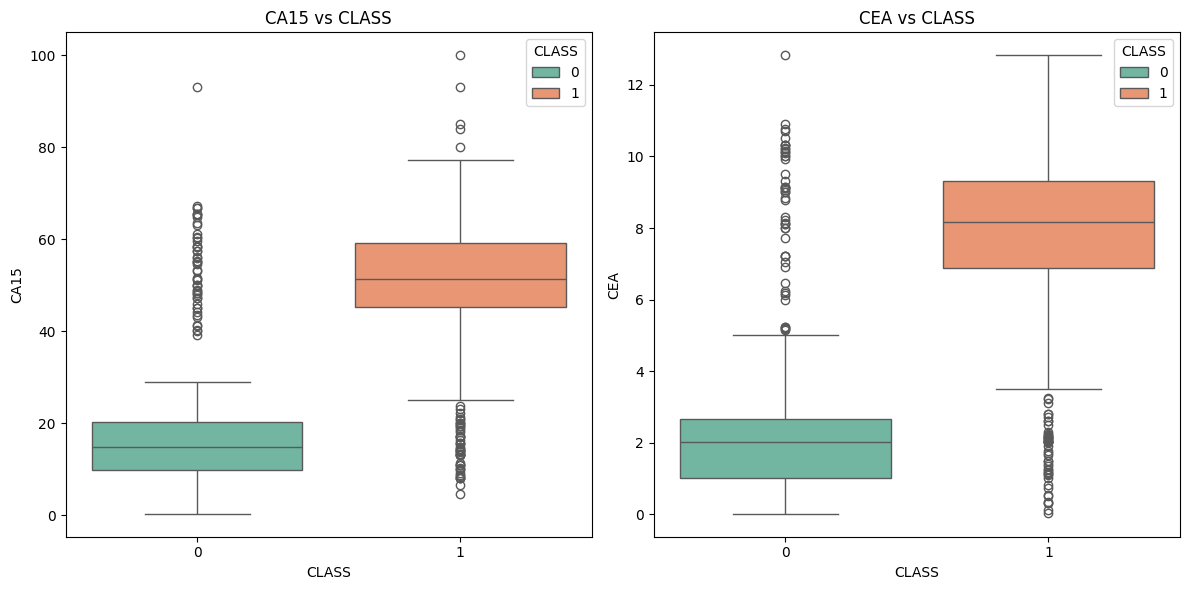

{'Correlations': CLASS    1.000000
 CA15     0.852288
 CEA      0.843010
 Name: CLASS, dtype: float64}

In [87]:
cancer_biomarkers = ['CA15', 'CEA']

# 1. Correlation with CLASS
biomarker_correlations = data[cancer_biomarkers + ['CLASS']].corr()['CLASS'].sort_values(ascending=False)

# 2. Boxplot visualization for each biomarker
plt.figure(figsize=(12, 6))
for i, biomarker in enumerate(cancer_biomarkers, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=data, x='CLASS', y=biomarker, palette="Set2", hue = "CLASS")
    plt.title(f'{biomarker} vs CLASS')
    plt.xlabel('CLASS')
    plt.ylabel(biomarker)
plt.tight_layout()
plt.show()


# Results
{
    "Correlations": biomarker_correlations,
}


### Results Summary:

The correlation analysis highlights the strong relationship between cancer-specific biomarkers (**CA15** and **CEA**) and the target variable `CLASS` (cancer presence). **CA15** shows a very high positive correlation (**0.85**), indicating its effectiveness as a diagnostic marker, particularly for breast cancer. Similarly, **CEA** demonstrates a strong positive correlation (**0.84**), reinforcing its role as a versatile biomarker for various types of cancer.

These findings emphasize the critical importance of **CA15** and **CEA** in identifying cancer presence and their potential as primary predictors in diagnostic models. Further analysis and validation could enhance their utility in clinical applications.

## Correlation Matrix

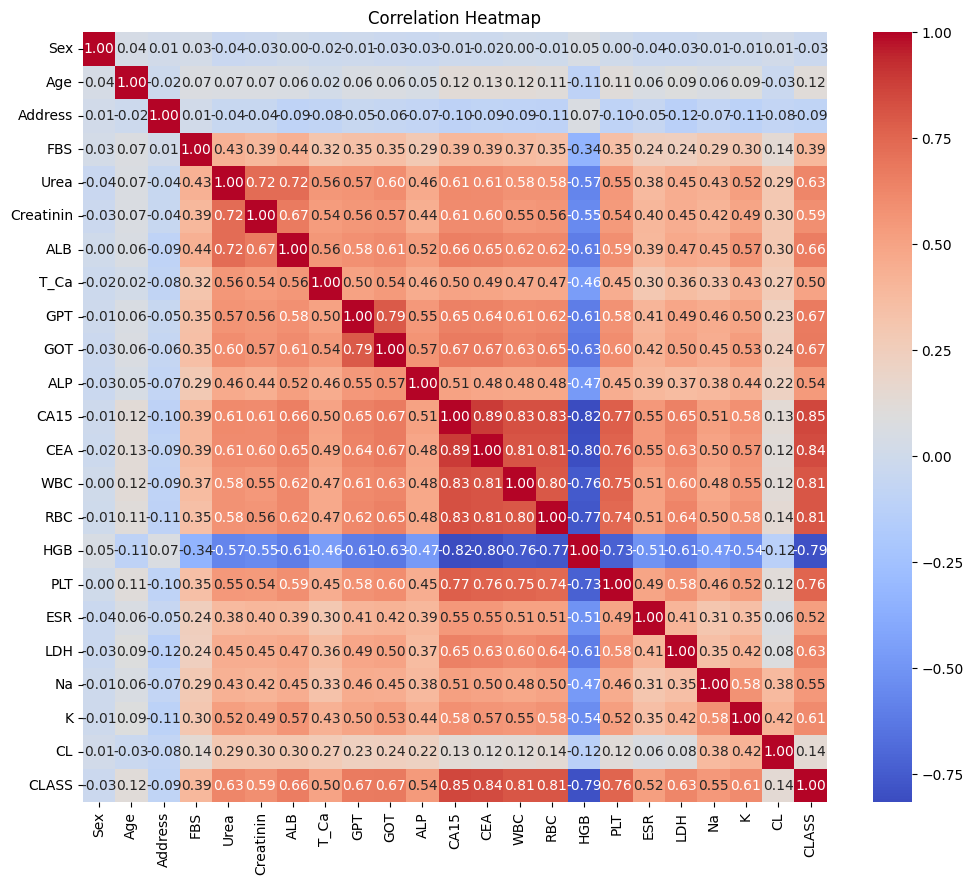

In [88]:
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

As we can see from the correlation matrix, several variables show very high correlation. Most notably, we focus our attention towards CA15 and CEA, which are two well known biomarkers and [studies](https://pmc.ncbi.nlm.nih.gov/articles/PMC5022658/) have shown that biomarkers such as these are already established and well known predictors of benign and malignant cancer.

This poses the question of whether CA15 and CEA are interesting variables to analyze.

To clear our minds, we take a look at Variance Inflation Factor

## Variance Inflation Factor

In [89]:
utils.get_vif(
  data,
  data.drop(columns='CLASS').columns
)

,Feature,VIF
0,const,663.048743
1,Sex,1.020131
2,Age,1.028438
3,Address,1.037707
4,FBS,1.324068
5,Urea,2.923543
6,Creatinin,2.550706
7,ALB,2.924009
8,T_Ca,1.761598
9,GPT,3.022997


CA15 and CEA both show a VIF value above the alerting threshold of $VIF > 5$. For this reason and the studies mentioned above, we ultimately decided not to include them because we concluded that an analysis regarding models with these variables included would not be of much interest.
More so, multicollinearity usually negatively affects the predictive power of the model but makes it difficult to interpret the individual coefficients of the predictors.

We will now proceed with feature selection on the remaining variables.

# Feature selection

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.metrics import roc_auc_score
import numpy as np

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [91]:
# Split the dataset into features and target
X = data.drop(columns=['CLASS', 'CA15', 'CEA'])
y = data['CLASS']

#print(X)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_train.shape[0])
print(X_valid.shape[0])
print(X_test.shape[0])

1461
487
487


### Feature Selection with Accuracy

We start our feature selection process by performing a forward selection using validation accuracy as the metric to evaluate the best performing variables. We concluded that a $1\%$ increase in accuracy would be significant enough.

In [92]:
acc_threshold = 0.01    # 1% improvement in accuracy
selected_features_accuracy = utils.accuracy_selection(X_train, y_train, acc_threshold)
print("Selected features based on accuracy:", selected_features_accuracy)

Selected features based on accuracy: ['RBC']


Accuracy-based feature selection only yielded 'RBC' (Red Blood Cells) as a sufficient feature.

### Feature Selection with AUC score

We then move on to do feature selection using the AUC Score as the metric instead 

In [93]:
auc_threshold = 0.05    # 5% improvement in AUC score
selected_features_auc = utils.auc_selection(X_train, y_train, auc_threshold)
print("Selected features based on auc:", selected_features_auc)

Selected features based on auc: ['WBC']


AUC-based feature selection only yielded 'WBC' (White Blood Cells) as a sufficient feature.

### Feature Selection with Random Forest

Finally, we tried another approach by employing Random Forest not as a classifier, but for feature selection only. 

To overcome the non-deterministic initialization of Random Forest, we decided to average the performance across 100 runs.

100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Aggregated Feature Importances over 100 iterations:
           Importance    StdDev
RBC          0.199990  0.034284
WBC          0.166929  0.030589
PLT          0.132044  0.023994
HGB          0.130006  0.027431
GPT          0.064660  0.012888
GOT          0.059692  0.015149
Na           0.058400  0.009135
Creatinin    0.042684  0.012431
LDH          0.033811  0.011350
ALP          0.033288  0.009006
K            0.023159  0.007817
ALB          0.016763  0.006348
Urea         0.011646  0.006115
ESR          0.009752  0.003522
CL           0.008148  0.001622
T_Ca         0.005245  0.002394
FBS          0.002697  0.000382
Age          0.001010  0.000203
Address      0.000074  0.000054
Sex          0.000002  0.000008


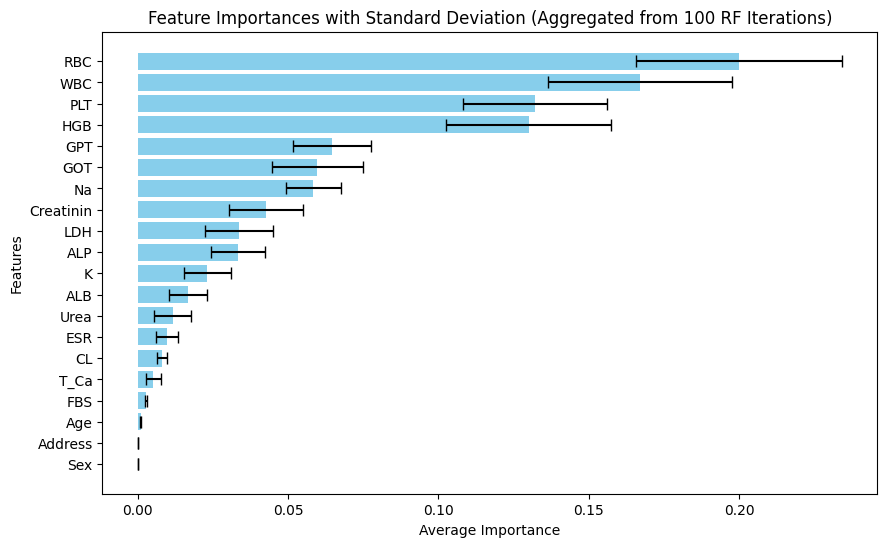

In [94]:
# Initialize a dictionary to store feature importances across iterations
importances_over_iterations = {column: [] for column in X.columns}

# Perform 100 iterations of training and evaluation
for _ in tqdm(range(100)):
    
    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(max_depth=6, random_state=None)
    rf_model.fit(X_train, y_train)

    # Predictions and evaluation
    y_pred_rf = rf_model.predict(X_valid)
    accuracy_rf = accuracy_score(y_valid, y_pred_rf)
    conf_matrix_rf = confusion_matrix(y_valid, y_pred_rf)

    # Collect feature importances
    importances = rf_model.feature_importances_
    for feature, importance in zip(X.columns, importances):
        importances_over_iterations[feature].append(importance)

# Compute average importance and standard deviation for each feature
average_importances = {feature: np.mean(importances) for feature, importances in importances_over_iterations.items()}
std_importances = {feature: np.std(importances) for feature, importances in importances_over_iterations.items()}

# Convert the results into a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Importance': average_importances,
    'StdDev': std_importances
}).sort_values(by='Importance', ascending=False)

# Display the final aggregated importance values with standard deviation
print("Aggregated Feature Importances over 100 iterations:")
print(importance_df)
selected_features_rf = importance_df[:4].index.to_list()


# Visualizing feature importances with error bars (standard deviation)
plt.figure(figsize=(10, 6))
plt.barh(importance_df.index, importance_df['Importance'], xerr=importance_df['StdDev'], capsize=4, color='skyblue')
plt.xlabel('Average Importance')
plt.ylabel('Features')
plt.title('Feature Importances with Standard Deviation (Aggregated from 100 RF Iterations)')
plt.gca().invert_yaxis()
plt.show()


As we can see from the output, Random Forest highlighted four main variables: 'RBC', 'WBC', 'PLT' (Platelet Count), 'HGB' (Hemoglobin).

# Logistic Regression

We will now proceed to compare three distinct Logistic Regression models built using the variables obtained from the three feature selection processes.

### Logistic Regression from Accuracy-based feature selection

10it [00:00, 78.09it/s]


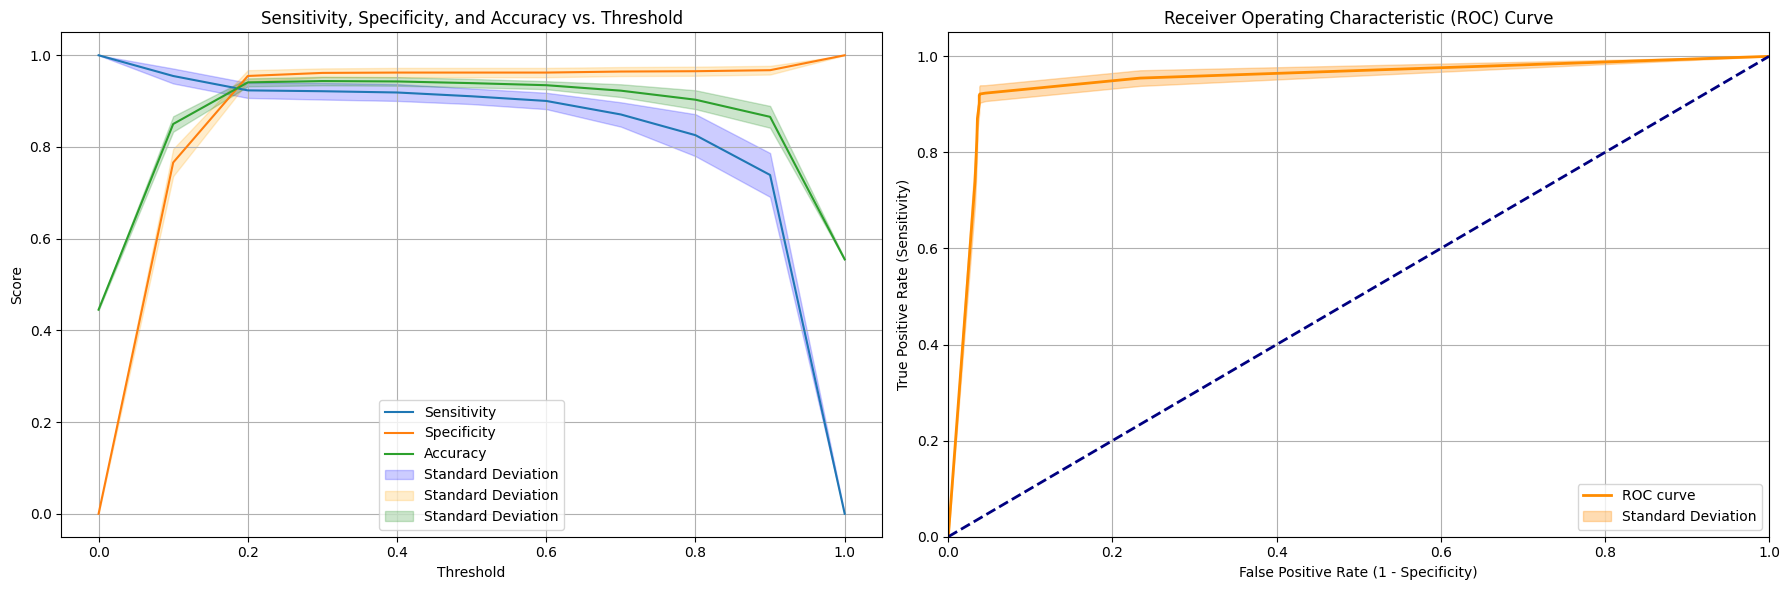

Best Threshold Index: 3, with value: 0.9419852419732917
AIC: 1031.5600761533565
BIC: 1042.9443028325475


In [95]:
X = data.drop(columns=['CLASS', 'CA15', 'CEA'])
y = data['CLASS']

thresholds, sensitivity, specificity, accuracy, aic, bic = utils.threshold_estimation(X, y, selected_features_accuracy)
utils.thresholds_plotter(thresholds, sensitivity, specificity, accuracy)

sensitivity_mean = sensitivity["mean"]
specificity_mean = specificity["mean"]
accuracy_mean = accuracy["mean"]
sums = []
for i, threshold in enumerate(thresholds):
    sums.append(0.4 * sensitivity_mean[i] + 0.4 * specificity_mean[i] + 0.2 * accuracy_mean[i])

best_threshold_index = np.argmax(sums)
print(f'Best Threshold Index: {best_threshold_index}, with value: {sums[best_threshold_index]}')
print(f'AIC: {aic[best_threshold_index]}')
print(f'BIC: {bic[best_threshold_index]}')

### Logistic Regression from AUC-based feature selection

10it [00:00, 78.02it/s]


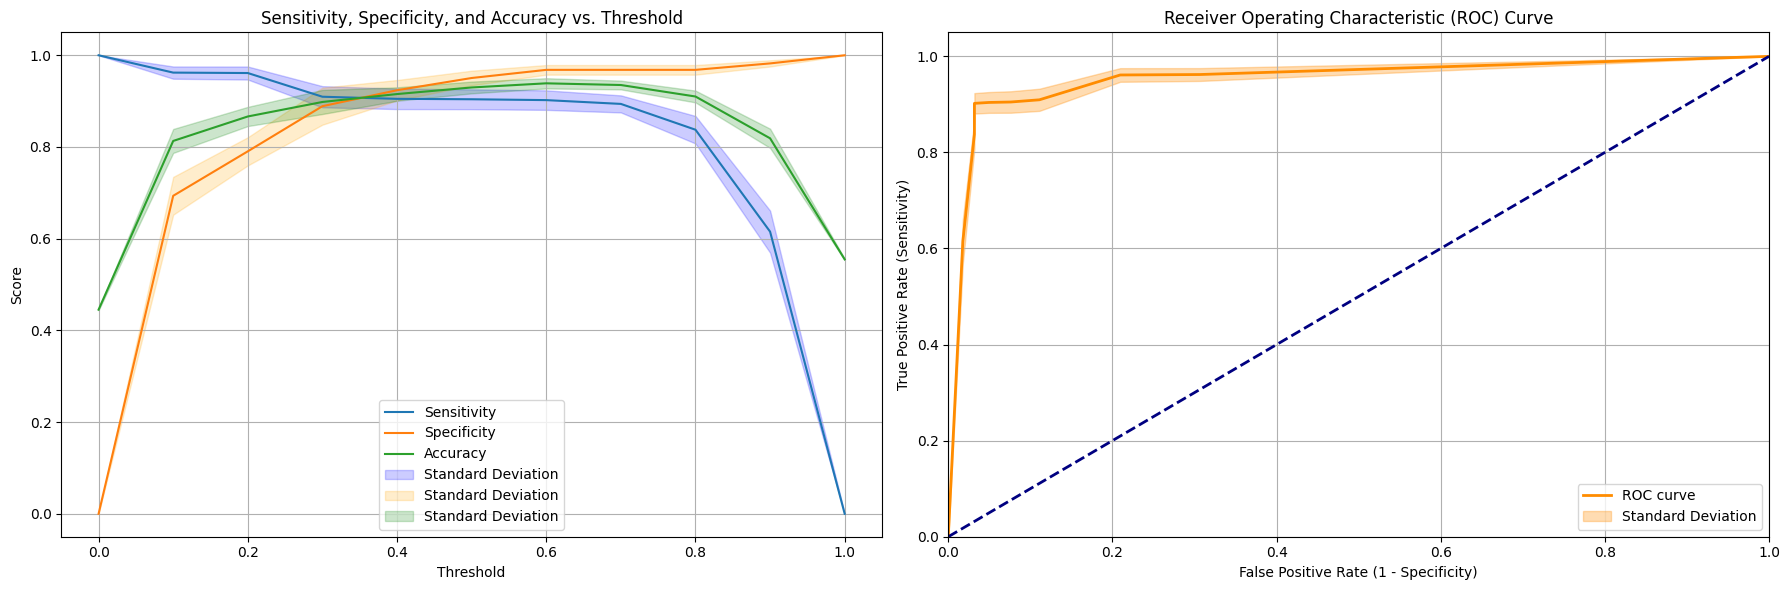

Best Threshold Index: 6, with value: 0.9359014699046884
AIC: 1084.7318442706573
BIC: 1096.1169835667931


In [96]:
X = data.drop(columns=['CLASS', 'CA15', 'CEA'])
y = data['CLASS']

thresholds, sensitivity, specificity, accuracy, aic, bic = utils.threshold_estimation(X, y, selected_features_auc)
utils.thresholds_plotter(thresholds, sensitivity, specificity, accuracy)

sensitivity_mean = sensitivity["mean"]
specificity_mean = specificity["mean"]
accuracy_mean = accuracy["mean"]
sums = []
for i, threshold in enumerate(thresholds):
    sums.append(0.4 * sensitivity_mean[i] + 0.4 * specificity_mean[i] + 0.2 * accuracy_mean[i])

best_threshold_index = np.argmax(sums)
print(f'Best Threshold Index: {best_threshold_index}, with value: {sums[best_threshold_index]}')
print(f'AIC: {aic[best_threshold_index]}')
print(f'BIC: {bic[best_threshold_index]}')

### Logistic Regression from Random Forest-based feature selection

10it [00:00, 12.04it/s]


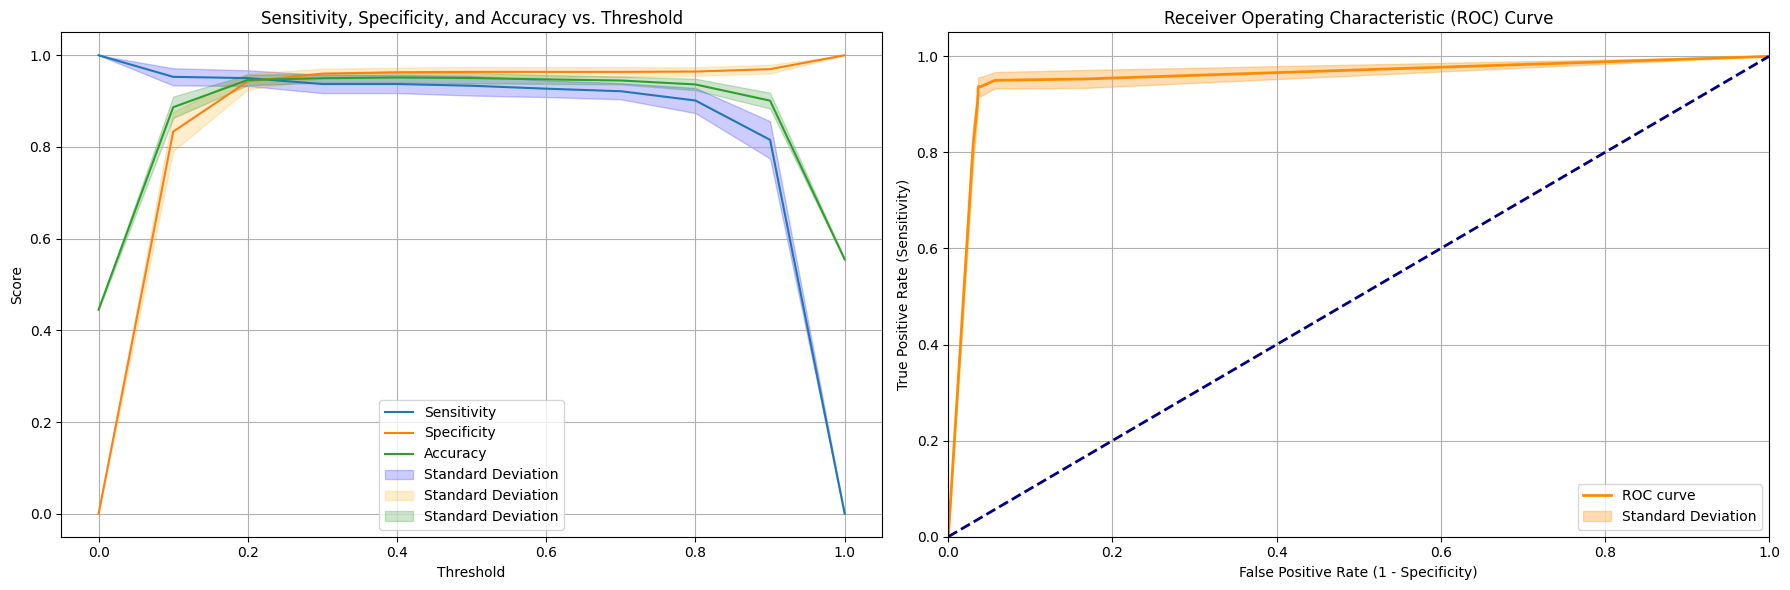

Best Threshold Index: 4, with value: 0.9504005648010074
AIC: 905.7016305082193
BIC: 934.1621972061967


In [97]:
X = data.drop(columns=['CLASS', 'CA15', 'CEA'])
y = data['CLASS']

thresholds, sensitivity, specificity, accuracy, aic, bic = utils.threshold_estimation(X, y, selected_features_rf)
utils.thresholds_plotter(thresholds, sensitivity, specificity, accuracy)

sensitivity_mean = sensitivity["mean"]
specificity_mean = specificity["mean"]
accuracy_mean = accuracy["mean"]
sums = []
for i, threshold in enumerate(thresholds):
    sums.append(0.4 * sensitivity_mean[i] + 0.4 * specificity_mean[i] + 0.2 * accuracy_mean[i])

best_threshold_index = np.argmax(sums)
print(f'Best Threshold Index: {best_threshold_index}, with value: {sums[best_threshold_index]}')
print(f'AIC: {aic[best_threshold_index]}')
print(f'BIC: {bic[best_threshold_index]}')

### Logistic Regression Results

Between the three models analyzed above, the one based on Random Forest feature selection is the one that performed the best. Even though this model is definetely more complex, by having four variables instead of just one as the first two models, it still achived the lowest AIC and BIC values, making a great performer overall. 

Moreover, it achieved the highest performance across all analyzed metrics.

We performed a weighted sum over three different metrics: Accuracy, Sensitivity and Specificity. We chose to give more weight to the latter two since in the context of medical analysis Sensitivity and Specificity help medical personnel understand how reliable a test is in identifying a disease or condition.

# Random Forest Classification

In [98]:
# Initialize lists for accuracies, sensitivities, and specificities
accuracies_rf = [[] for _ in range(10)]
sensitivities_rf = [[] for _ in range(10)]
specificities_rf = [[] for _ in range(10)]

# Perform 100 iterations of training and evaluation
for _ in tqdm(range(100)):

    for i in range(1, 11):
        # Initialize and train the Random Forest model
        rf_model = RandomForestClassifier(max_depth=i, random_state=None)
        rf_model.fit(X_train[selected_features_rf], y_train)

        # Predictions and evaluation
        y_pred_rf = rf_model.predict(X_valid[selected_features_rf])

        # Compute accuracy
        accuracy_rf = accuracy_score(y_valid, y_pred_rf)
        accuracies_rf[i-1].append(accuracy_rf)

        # Compute sensitivity and specificity
        tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_rf).ravel()  # Extract confusion matrix values
        sensitivity_rf = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity: True Positives / (True Positives + False Negatives)
        specificity_rf = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity: True Negatives / (True Negatives + False Positives)

        sensitivities_rf[i-1].append(sensitivity_rf)
        specificities_rf[i-1].append(specificity_rf)

# Convert lists to numpy arrays and calculate averages
accuracies_rf = np.array(accuracies_rf)
sensitivities_rf = np.array(sensitivities_rf)
specificities_rf = np.array(specificities_rf)

# Compute the average metrics for each depth
accuracy_averages = np.mean(accuracies_rf, axis=1)
sensitivity_averages = np.mean(sensitivities_rf, axis=1)
specificity_averages = np.mean(specificities_rf, axis=1)

# Print results
print("Average Accuracies:", accuracy_averages)
print("Average Sensitivities:", sensitivity_averages)
print("Average Specificities:", specificity_averages)


100%|██████████| 100/100 [02:06<00:00,  1.27s/it]

Average Accuracies: [0.93287474 0.9423614  0.94205339 0.93963039 0.93753593 0.93650924
 0.93336756 0.92946612 0.9274538  0.92507187]
Average Sensitivities: [0.90348039 0.92612745 0.92539216 0.91960784 0.91460784 0.91254902
 0.90872549 0.90960784 0.9052451  0.90161765]
Average Specificities: [0.9540636  0.9540636  0.9540636  0.9540636  0.9540636  0.95378092
 0.95113074 0.94378092 0.9434629  0.9419788 ]


From these results we can see that the best choice is $ \ \texttt{max\_depth}$ = 2.

Here are the results obtained with such depth on the test set.

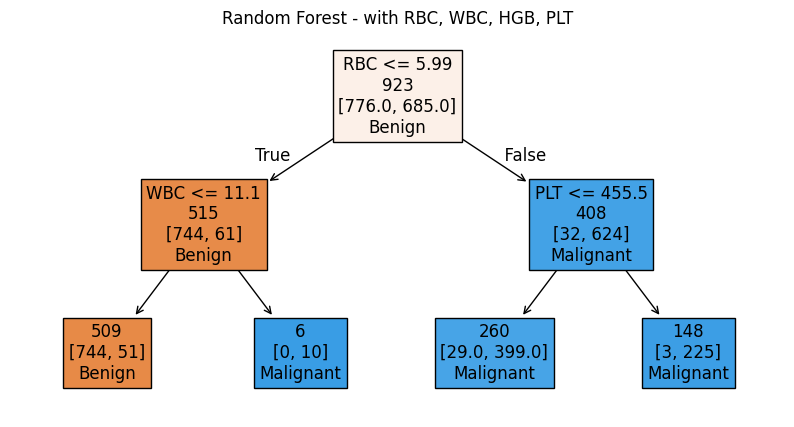

Test accuracy: 0.9691991786447639
Test sensitivity: 0.9567307692307693
Test specificity: 0.978494623655914


,Predicted 0,Predicted 1
0,273,6
1,9,199


In [99]:

rf_model = RandomForestClassifier(max_depth=2, random_state=None)
rf_model.fit(X_train[selected_features_rf], y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test[selected_features_rf])
accuracy_rf = accuracy_score(y_test, y_pred_rf)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
tn, fp, fn, tp = conf_matrix_rf.ravel()
sensitivity_rf = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity: True Positives / (True Positives + False Negatives)
specificity_rf = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity: True Negatives / (True Negatives + False Positives)

tree_rf = rf_model.estimators_[0]

# Visualizing the Decision Tree with only feature names and class labels, excluding other details
plt.figure(figsize=(10, 5))
plot_tree(tree_rf, 
          filled=True, 
          feature_names=X[selected_features_rf].columns, 
          class_names=['Benign', 'Malignant'],  
          label='none',  
          impurity=False,  
          proportion=False,  
          node_ids=False, 
          fontsize=12)
plt.title("Random Forest - with RBC, WBC, HGB, PLT")
plt.show()

print(f'Test accuracy: {accuracy_rf}')
print(f'Test sensitivity: {sensitivity_rf}')
print(f'Test specificity: {specificity_rf}')

conf_matrix_rf = pd.DataFrame(conf_matrix_rf, columns=['Predicted 0', 'Predicted 1'])
conf_matrix_rf


# GAM   Grandi smeni, smeni duri cazzi amari cazzi in golas

In [100]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [102]:
%%R
library(mgcv) 
library(PerformanceAnalytics) 

### Cross-validation for estimating the value of s(var) 

In [103]:
from sklearn.model_selection import StratifiedKFold

def gam_cross_val(X, y, selected_features, with_PLT = True):
  # Initialize StratifiedKFold
  kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

  # Initialize lists to store results
  s_array = []
  degree_of_freedom_array = []
  aic_array = []

  # Perform cross-validation
  for train_index, test_index in tqdm(kf.split(X[selected_features], y)):
      X_train, X_test = X[selected_features].iloc[train_index], X[selected_features].iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      X_train = sm.add_constant(X_train)
      X_test = sm.add_constant(X_test)

      train_data = pd.concat([X_train, y_train], axis = 1)
      %Rpush train_data
      
      # Gam model
      if with_PLT:
        %R gamfit <- gam(CLASS ~ s(HGB) + s(PLT) + s(WBC) + s(RBC), data = train_data, family = binomial)
        pass
      else:
        %R gamfit <- gam(CLASS ~ s(HGB) + PLT + s(WBC) + s(RBC), data = train_data, family = binomial)
        pass
      
      # Degree of Freedom
      %R summ <- summary(gamfit)
      %R edf <- summ$s.table[, "edf"]
      %R edf_list <- as.list(edf)
      
      %Rpull edf_list
      # Converti l'oggetto Rpy2 ListSexpVector in un dizionario Python
      edf_dict = {str(edf_list.names[i]): edf_list[i][0] for i in range(len(edf_list))}
      edf_dict = list(edf_dict.values())
      
      degree_of_freedom_array.append(edf_dict)
      
      #AIC
      %R -o aic aic=AIC(gamfit)
      aic_array.append(aic[0])
      
      #s (spline)
      %R -o spline spline=round(gamfit$sp, 4)
      s_array.append(spline)
      
      
  degree_of_freedom_array = np.array(degree_of_freedom_array)
  aic_array = np.array(aic_array)
  s_array = np.array(s_array)

  df_mean = np.mean(degree_of_freedom_array, axis=0)
  df_std = np.std(degree_of_freedom_array, axis=0)
  
  aic_mean = np.mean(aic_array)
  aic_std = np.std(aic_array)

  s_mean = np.mean(s_array, axis=0)
  s_std = np.std(s_array, axis=0)


  df = {
    "mean": df_mean,
    "std": df_std
  }
  
  AIC = {
    "mean": aic_mean,
    "std": aic_std
  }
  
  s = {
    "mean": s_mean,
    "std": s_std
  }

  return df, AIC, s 

10it [00:09,  1.01it/s]


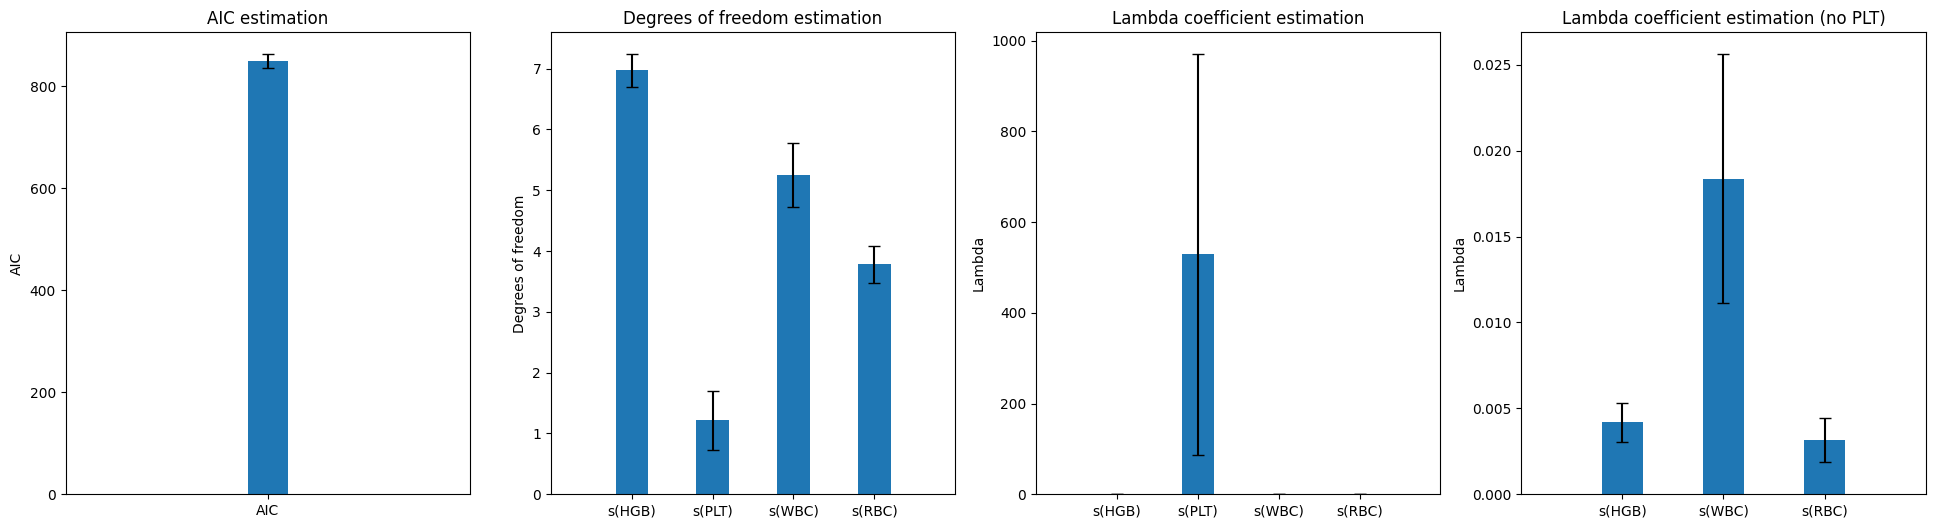

In [104]:
df, AIC, s = gam_cross_val(X, y, selected_features_rf)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

axes[0].set_title("AIC estimation")
axes[0].set_ylabel("AIC")
axes[0].bar([1], AIC['mean'], yerr=AIC['std'], capsize=4, width=0.4)
axes[0].set_xlim(-1,3)
axes[0].set_xticks(ticks=[1], labels=['AIC'])

axes[1].set_title("Degrees of freedom estimation")
axes[1].set_ylabel("Degrees of freedom")
axes[1].bar([1,2,3,4], df['mean'], yerr=df['std'], capsize=4, width=0.4)
axes[1].set_xlim(0,5)
axes[1].set_xticks(ticks=[1,2,3,4], labels=['s(HGB)', 's(PLT)', 's(WBC)', 's(RBC)'])

axes[2].set_title("Lambda coefficient estimation")
axes[2].set_ylabel("Lambda")
axes[2].bar([1,2,3,4], s['mean'], yerr=s['std'], capsize=4, width=0.4)
axes[2].set_xlim(0,5)
axes[2].set_xticks(ticks=[1,2,3,4], labels=['s(HGB)', 's(PLT)', 's(WBC)', 's(RBC)'])

axes[3].set_title("Lambda coefficient estimation (no PLT)")
axes[3].set_ylabel("Lambda")
axes[3].bar([1,2,3], s['mean'][[0,2,3]], yerr=s['std'][[0,2,3]], capsize=4, width=0.4)
axes[3].set_xlim(0,4)
axes[3].set_xticks(ticks=[1,2,3], labels=['s(HGB)', 's(WBC)', 's(RBC)'])

10it [00:04,  2.16it/s]


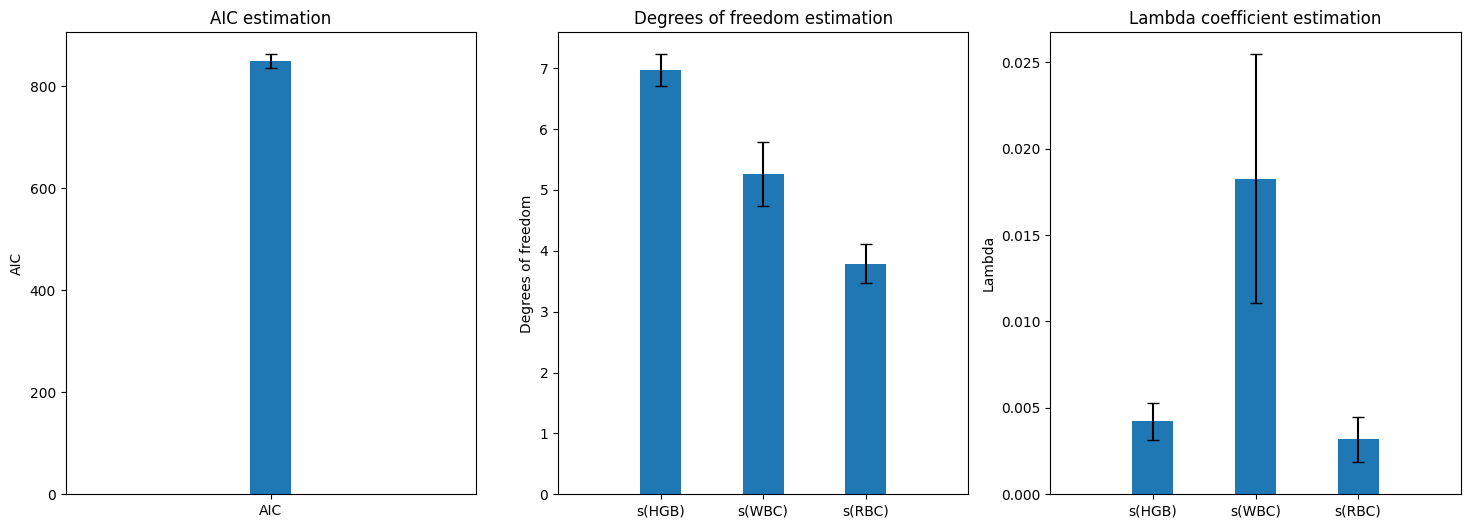

In [105]:
df_no_PLT, AIC_no_PLT, s_no_PLT = gam_cross_val(X, y, selected_features_rf, with_PLT=False)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].set_title("AIC estimation")
axes[0].set_ylabel("AIC")
axes[0].bar([1], AIC_no_PLT['mean'], yerr=AIC_no_PLT['std'], capsize=4, width=0.4)
axes[0].set_xlim(-1,3)
axes[0].set_xticks(ticks=[1], labels=['AIC'])

axes[1].set_title("Degrees of freedom estimation")
axes[1].set_ylabel("Degrees of freedom")
axes[1].bar([1,2,3], df_no_PLT['mean'], yerr=df_no_PLT['std'], capsize=4, width=0.4)
axes[1].set_xlim(0,4)
axes[1].set_xticks(ticks=[1,2,3], labels=['s(HGB)', 's(WBC)', 's(RBC)'])

axes[2].set_title("Lambda coefficient estimation")
axes[2].set_ylabel("Lambda")
axes[2].bar([1,2,3], s_no_PLT['mean'], yerr=s_no_PLT['std'], capsize=4, width=0.4)
axes[2].set_xlim(0,4)
axes[2].set_xticks(ticks=[1,2,3], labels=['s(HGB)', 's(WBC)', 's(RBC)'])

Comparison between models

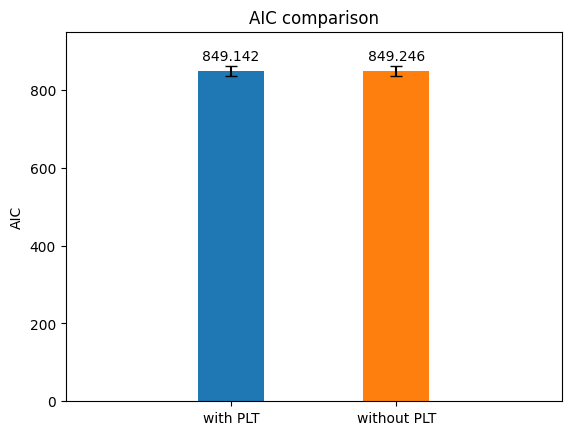

In [106]:
plt.title("AIC comparison")
plt.ylabel("AIC")
bar1 = plt.bar([1], AIC['mean'], yerr=AIC['std'], capsize=4, width=0.4)
bar2 = plt.bar([2], AIC_no_PLT['mean'], yerr=AIC_no_PLT['std'], capsize=4, width=0.4)
plt.xlim(0,3)
plt.ylim(0,950)
plt.xticks(ticks=[1,2], labels=['with PLT', 'without PLT'])

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height + 20, f'{height:.3f}', ha='center', va='bottom')